In [85]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier


import joblib
import warnings
import config
warnings.simplefilter("ignore")

In [86]:
train_data = pd.read_csv(config.TRAIN_DATA)
X,y = train_data.drop("Exited",axis=1),train_data["Exited"]
X.shape

(9000, 13)

In [87]:
test_data = pd.read_csv(config.TEST_DATA)
y_test = test_data["Exited"]
test_data = test_data.drop("Exited",axis=1)

In [4]:
X.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,4031,15808760,Evseev,603,Spain,Female,42,6,0.00,1,1,1,90437.87
1,4999,15792916,Ositadimma,559,Spain,Female,40,7,144470.77,1,1,1,18917.95
2,5120,15668142,Chang,700,France,Male,37,3,77608.46,2,1,1,175373.46
3,7159,15591010,McDonald,434,Germany,Male,55,8,109339.17,2,1,0,96405.88
4,3491,15809137,Sagese,453,France,Male,29,6,0.00,1,0,0,198376.02


During the exploratory data analysis, I saw that none the numerical column is normally distributed and some of them are right skewed i.e. Age and others are left skewed i.e. credit score.

So to make data normally distribute I apply box-cox transfromation on them.

In [5]:
drop_feat = ["RowNumber","CustomerId", "Surname", "HasCrCard"]
num_feat = ["CreditScore", "Age", "Tenure", "Balance","EstimatedSalary"]
cat_feat = ["Geography","Gender","IsActiveMember"]

In [6]:
categorical_transformer = Pipeline(steps=[
    ('onehotenc',OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps = [
    ('power_transform',PowerTransformer())
])

In [7]:
col_transformer = ColumnTransformer(transformers = [
    ('drop_columns', 'drop', drop_feat),
    ('numeric_prcessing',numerical_transformer,num_feat),
    ('categorical_processing',categorical_transformer,cat_feat)
],remainder='passthrough')

In [8]:
data_preprocessing_pipline = Pipeline([
    ('transfrom_column',col_transformer)
])

In [9]:
data_preprocessing_pipline.fit(X)

Pipeline(steps=[('transfrom_column',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop_columns', 'drop',
                                                  ['RowNumber', 'CustomerId',
                                                   'Surname', 'HasCrCard']),
                                                 ('numeric_prcessing',
                                                  Pipeline(steps=[('power_transform',
                                                                   PowerTransformer())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'EstimatedSalary']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('onehotenc',
                                                      

In [10]:
X_transformed = data_preprocessing_pipline.transform(X)

In [11]:
data_preprocessing_pipline.named_steps

{'transfrom_column': ColumnTransformer(remainder='passthrough',
                   transformers=[('drop_columns', 'drop',
                                  ['RowNumber', 'CustomerId', 'Surname',
                                   'HasCrCard']),
                                 ('numeric_prcessing',
                                  Pipeline(steps=[('power_transform',
                                                   PowerTransformer())]),
                                  ['CreditScore', 'Age', 'Tenure', 'Balance',
                                   'EstimatedSalary']),
                                 ('categorical_processing',
                                  Pipeline(steps=[('onehotenc',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['Geography', 'Gender', 'IsActiveMember'])])}

In [12]:
cat_cols = data_preprocessing_pipline.named_steps['transfrom_column'].transformers_[2][1].named_steps['onehotenc'].get_feature_names(cat_feat)

In [13]:
num_feat + cat_cols.tolist() + ["NumOfProducts"]

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'EstimatedSalary',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Female',
 'Gender_Male',
 'IsActiveMember_0',
 'IsActiveMember_1',
 'NumOfProducts']

In [14]:
X_transformed = pd.DataFrame(X_transformed,columns = num_feat + cat_cols.tolist() + ["NumOfProducts"])
X_test  =  pd.DataFrame(data_preprocessing_pipline.transform(test_data),columns = num_feat + cat_cols.tolist() + ["NumOfProducts"])

In [15]:
def create_folds(df,K):
    """ Create K-folds in the data"""
     #create a k-fold column and initialise it with -1
    df["kfold"] = -1
    
    #intialise kfold class
    kf = StratifiedKFold(n_splits=K)
    
    #filling kfold columns
    for f,(t_,v_) in enumerate(kf.split(X=df,y=y)):
        df.loc[v_,'kfold'] = f
    return df

In [16]:
def featureImpPlot(feat_imp):
    """Plot bar chart for feature Importance"""
    plt.figure()
    feat_imp_df = pd.DataFrame({'Feature':X_transformed.columns.tolist(),'Importance':feat_imp})
    feat_imp_df = feat_imp_df.sort_values(by = 'Importance',ascending=False)
    sns.barplot(x='Importance',y='Feature',data=feat_imp_df)
    plt.show()

In [17]:
def get_score(df,model,k):
    
    df = create_folds(df,k)
    scores = []
    for fold in range(0,k):
        df_train = df[df["kfold"] != fold].reset_index(drop=True)
        df_valid = df[df["kfold"] == fold].reset_index(drop=True)

        x_train = df_train.drop(['kfold','Exited'],axis=1).values
        y_train = df_train.Exited.values
        
        
        x_valid = df_valid.drop(['kfold','Exited'],axis=1).values
        y_valid = df_valid.Exited.values
        
        model.fit(x_train,y_train)
        y_pred = model.predict(x_valid)
        
        scores.append(metrics.roc_auc_score(y_valid,y_pred))
        print(f"Classfication Report for {fold} Fold")
        print(metrics.classification_report(y_valid,y_pred,labels=[0,1]))

    score = np.mean(scores)   
    return score

In [18]:
df = X_transformed.copy()
df["Exited"] = y

In [19]:
def model_performance(model):
    print("Performance on Training Data.............")
    score = get_score(df,model,k=3)
    print(f"roc_auc Score on Training data : {score} \n")
    plt.figure()
    metrics.plot_confusion_matrix(model,X_transformed.values,y)
    plt.title("Confusion Matrix(Train Data)")
    plt.plot()
    print("Performance on Test Data.............")
    print(f"roc_auc Score on Test data : {metrics.roc_auc_score(model.predict(X_test.values),y_test)} \n")
    
    plt.figure()
    metrics.plot_confusion_matrix(model,X_test.values,y_test)
    plt.title("Confusion Matrix(Test Data)")
    plt.plot()

## Logistic Regression

Performance on Training Data.............
Classfication Report for 0 Fold
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2387
           1       0.65      0.22      0.32       613

    accuracy                           0.82      3000
   macro avg       0.74      0.59      0.61      3000
weighted avg       0.79      0.82      0.78      3000

Classfication Report for 1 Fold
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2387
           1       0.60      0.24      0.34       613

    accuracy                           0.81      3000
   macro avg       0.71      0.60      0.62      3000
weighted avg       0.78      0.81      0.78      3000

Classfication Report for 2 Fold
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2386
           1       0.60      0.22      0.32       614

    accuracy                           0.81 

<Figure size 432x288 with 0 Axes>

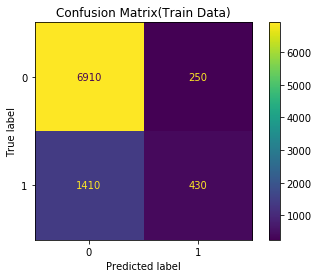

<Figure size 432x288 with 0 Axes>

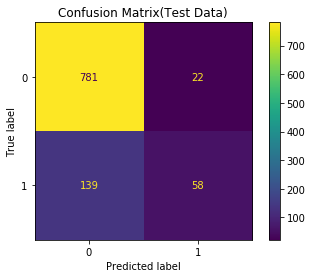

In [69]:
lr_model = LogisticRegression(C=10)
model_performance(lr_model)

## Support Vector Classifier

Performance on Training Data.............
Classfication Report for 0 Fold
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2387
           1       0.75      0.40      0.53       613

    accuracy                           0.85      3000
   macro avg       0.81      0.69      0.72      3000
weighted avg       0.84      0.85      0.83      3000

Classfication Report for 1 Fold
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2387
           1       0.82      0.42      0.56       613

    accuracy                           0.86      3000
   macro avg       0.84      0.70      0.74      3000
weighted avg       0.86      0.86      0.84      3000

Classfication Report for 2 Fold
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2386
           1       0.73      0.43      0.54       614

    accuracy                           0.85 

<Figure size 432x288 with 0 Axes>

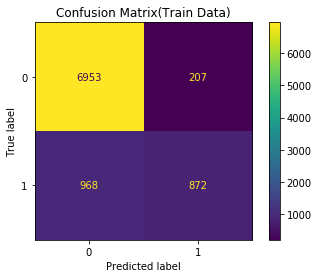

<Figure size 432x288 with 0 Axes>

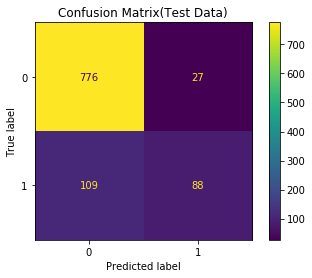

In [70]:
svc_model = SVC(kernel="rbf",C=10)
model_performance(svc_model)

## Random Forest Classifer

Performance on Training Data.............
Classfication Report for 0 Fold
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2387
           1       0.76      0.44      0.55       613

    accuracy                           0.86      3000
   macro avg       0.82      0.70      0.73      3000
weighted avg       0.85      0.86      0.84      3000

Classfication Report for 1 Fold
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2387
           1       0.77      0.44      0.56       613

    accuracy                           0.86      3000
   macro avg       0.82      0.70      0.74      3000
weighted avg       0.85      0.86      0.84      3000

Classfication Report for 2 Fold
              precision    recall  f1-score   support

           0       0.88      0.96      0.91      2386
           1       0.74      0.48      0.58       614

    accuracy                           0.86 

<Figure size 432x288 with 0 Axes>

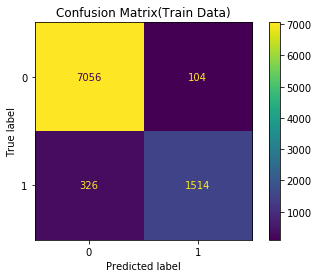

<Figure size 432x288 with 0 Axes>

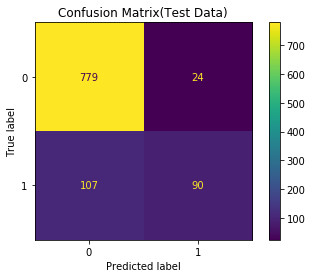

In [71]:
rf_model = RandomForestClassifier(n_estimators=50)
model_performance(rf_model)

## XGBClassifier

Performance on Training Data.............
Classfication Report for 0 Fold
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2387
           1       0.76      0.47      0.58       613

    accuracy                           0.86      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000

Classfication Report for 1 Fold
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2387
           1       0.75      0.50      0.60       613

    accuracy                           0.86      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.86      0.85      3000

Classfication Report for 2 Fold
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2386
           1       0.76      0.50      0.60       614

    accuracy                           0.86 

<Figure size 432x288 with 0 Axes>

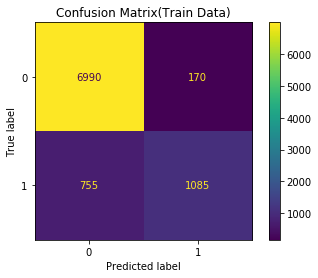

<Figure size 432x288 with 0 Axes>

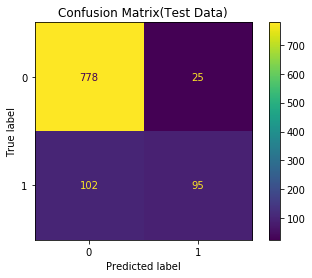

In [72]:
xgb_model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=4)
model_performance(xgb_model)

## AdaBoost Classifier

Performance on Training Data.............
Classfication Report for 0 Fold
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2387
           1       0.73      0.45      0.56       613

    accuracy                           0.85      3000
   macro avg       0.80      0.70      0.74      3000
weighted avg       0.84      0.85      0.84      3000

Classfication Report for 1 Fold
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2387
           1       0.74      0.49      0.59       613

    accuracy                           0.86      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000

Classfication Report for 2 Fold
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      2386
           1       0.71      0.48      0.58       614

    accuracy                           0.85 

<Figure size 432x288 with 0 Axes>

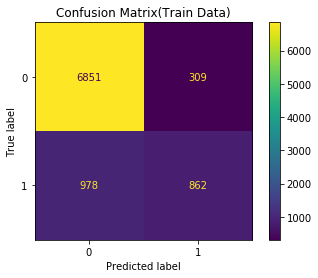

<Figure size 432x288 with 0 Axes>

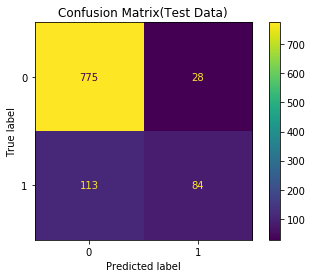

In [73]:
adb_model = AdaBoostClassifier()
model_performance(adb_model)

## Light GBMClassifier

Performance on Training Data.............
Classfication Report for 0 Fold
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2387
           1       0.75      0.47      0.58       613

    accuracy                           0.86      3000
   macro avg       0.81      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000

Classfication Report for 1 Fold
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2387
           1       0.74      0.49      0.59       613

    accuracy                           0.86      3000
   macro avg       0.81      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000

Classfication Report for 2 Fold
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      2386
           1       0.73      0.51      0.60       614

    accuracy                           0.86 

<Figure size 432x288 with 0 Axes>

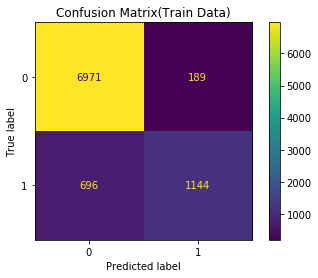

<Figure size 432x288 with 0 Axes>

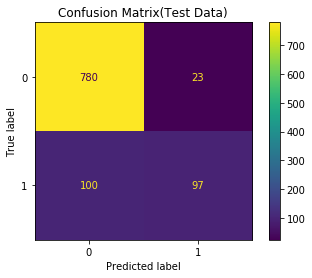

In [74]:
lgbm_model = LGBMClassifier()
model_performance(lgbm_model)

## CatBoost Classifier

3	total: 34.6s	remaining: 20.9s
623:	learn: 0.2925383	total: 34.6s	remaining: 20.9s
624:	learn: 0.2925382	total: 34.7s	remaining: 20.8s
625:	learn: 0.2925382	total: 34.7s	remaining: 20.7s
626:	learn: 0.2925381	total: 34.8s	remaining: 20.7s
627:	learn: 0.2925381	total: 34.8s	remaining: 20.6s
628:	learn: 0.2925352	total: 34.8s	remaining: 20.6s
629:	learn: 0.2925344	total: 34.9s	remaining: 20.5s
630:	learn: 0.2924645	total: 35s	remaining: 20.4s
631:	learn: 0.2924632	total: 35s	remaining: 20.4s
632:	learn: 0.2924632	total: 35s	remaining: 20.3s
633:	learn: 0.2924599	total: 35.1s	remaining: 20.3s
634:	learn: 0.2924591	total: 35.2s	remaining: 20.2s
635:	learn: 0.2924591	total: 35.2s	remaining: 20.1s
636:	learn: 0.2924589	total: 35.3s	remaining: 20.1s
637:	learn: 0.2924588	total: 35.3s	remaining: 20s
638:	learn: 0.2923394	total: 35.4s	remaining: 20s
639:	learn: 0.2923394	total: 35.4s	remaining: 19.9s
640:	learn: 0.2922712	total: 35.5s	remaining: 19.9s
641:	learn: 0.2920896	total: 35.5s	remaini

<Figure size 432x288 with 0 Axes>

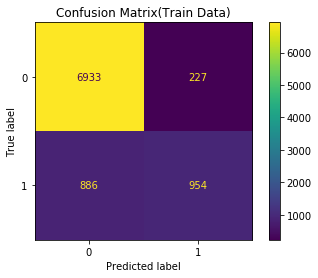

<Figure size 432x288 with 0 Axes>

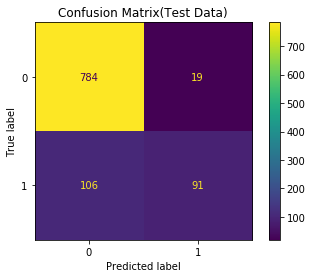

In [28]:
catb_model = CatBoostClassifier(task_type="GPU",loss_function='Logloss')
model_performance(catb_model)

Performance on Training Data.............
Classfication Report for 0 Fold
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      2387
           1       0.49      0.73      0.59       613

    accuracy                           0.79      3000
   macro avg       0.71      0.77      0.72      3000
weighted avg       0.83      0.79      0.80      3000

Classfication Report for 1 Fold
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      2387
           1       0.48      0.75      0.59       613

    accuracy                           0.79      3000
   macro avg       0.70      0.77      0.72      3000
weighted avg       0.83      0.79      0.80      3000

Classfication Report for 2 Fold
              precision    recall  f1-score   support

           0       0.93      0.79      0.85      2386
           1       0.48      0.78      0.59       614

    accuracy                           0.78 

<Figure size 432x288 with 0 Axes>

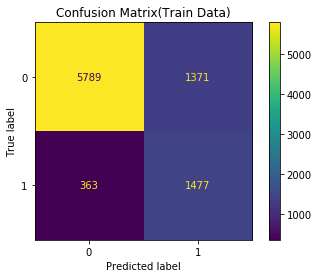

<Figure size 432x288 with 0 Axes>

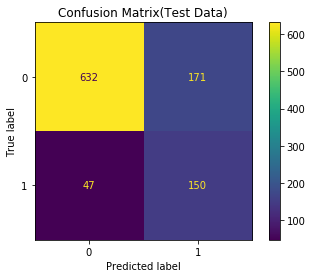

In [29]:
brf_model = BalancedRandomForestClassifier(n_estimators = 150,
                                            max_depth=9,
                                            min_samples_split = 5,
                                            bootstrap= True,
                                            max_features='auto',
                                            oob_score =False,
                                            min_samples_leaf=8,random_state=202020)
model_performance(brf_model)

In [30]:
metrics.classification_report(brf_model.predict(X_test),y_test)

'              precision    recall  f1-score   support\n\n           0       0.79      0.93      0.85       679\n           1       0.76      0.47      0.58       321\n\n    accuracy                           0.78      1000\n   macro avg       0.77      0.70      0.72      1000\nweighted avg       0.78      0.78      0.77      1000\n'

In [31]:
metrics.accuracy_score(brf_model.predict(X_transformed),y)

0.8073333333333333

In [82]:
#make a pipline for balanced random forest tree model
brf_pipeline = Pipeline(steps=[
    ('Data Preprocessing Pipline',data_preprocessing_pipline),
    ('Balanced Random Forest Classifier',BalancedRandomForestClassifier(n_estimators = 150,
                                            max_depth=9,
                                            min_samples_split = 5,
                                            bootstrap= True,
                                            max_features='auto',
                                            oob_score =False,
                                            min_samples_leaf=8,random_state=202020))
])

In [83]:
brf_pipeline.fit(X,y)

Pipeline(steps=[('Data Preprocessing Pipline',
                 Pipeline(steps=[('transfrom_column',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop_columns',
                                                                   'drop',
                                                                   ['RowNumber',
                                                                    'CustomerId',
                                                                    'Surname',
                                                                    'HasCrCard']),
                                                                  ('numeric_prcessing',
                                                                   Pipeline(steps=[('power_transform',
                                                                                    PowerTransformer())]),
                                         

In [50]:
test_data.iloc[0].values

array([2577, 15673529, 'Lombardo', 645, 'Spain', 'Male', 36, 4, 59893.85,
       2, 1, 0, 43999.64], dtype=object)

In [64]:
data = test_data.iloc[0].values
sample = pd.DataFrame(data.reshape(1,13),columns=test_data.columns)

In [84]:
joblib.dump(brf_pipeline,"./model/model.joblib")

['./model/model.joblib']